# Find the perpendicular distance from a point to each isochrone as a function of age and also direct distance from Gaia parameters


In [27]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
os.chdir('Data')
pkl_file = open('isochrones.pkl', 'rb')
stacked_isochrones = pickle.load(pkl_file)

pkl_file = open('columns.pkl', 'rb')
x_columns = pickle.load(pkl_file)

pkl_file = open('x_values.pkl', 'rb')
x_values = pickle.load(pkl_file)

pkl_file = open('isoc_cols.pkl', 'rb')
isoc_columns = pickle.load(pkl_file)

x_input=pd.read_csv('x_input')
x_input_err=pd.read_csv('x_input_err')

os.chdir('..')

In [28]:
import torch
def find_nearest(array, value):
    #array = np.asarray(array)
    idx = (torch.abs(array - value)).argmin()
    return array[idx],idx

def isochrone_selector(feh,age):
    '''if(feh<-4 or feh>0.5):
        raise NotImplementedError
    if(age<5 or age>10.3):
        raise NotImplementedError
    else:'''
    logagegrid = torch.tensor(np.linspace(5,10.3,105))
    fehgrid = torch.tensor(np.linspace(-4,0.5,90))
    feh,feh_idx=find_nearest(fehgrid,feh)
    age,age_idx=find_nearest(logagegrid,age)

    return feh_idx*len(logagegrid)+age_idx

def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

In [29]:
stacked_isochrones.shape

(9450, 458, 15)

# Find the perpendicular values

In [30]:
stacked_isochrones=torch.tensor(stacked_isochrones)

In [31]:
x_values=torch.tensor(x_values)

In [32]:
stacked_isochrones.shape

torch.Size([9450, 458, 15])

(20.0, -15.0)

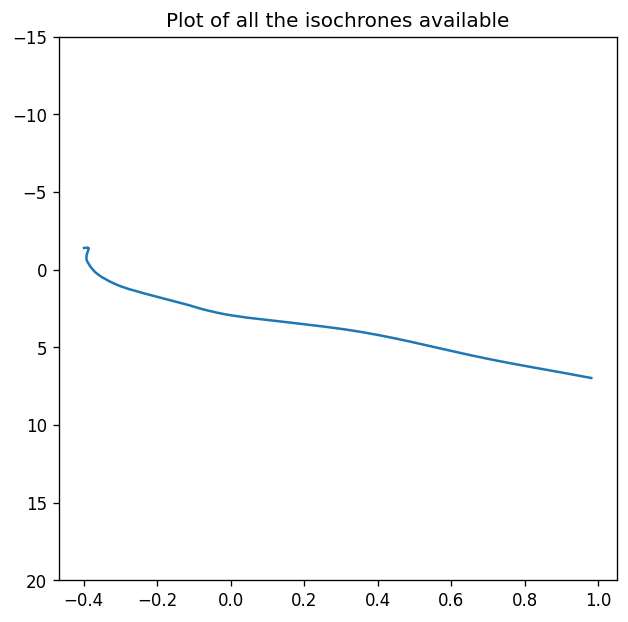

In [33]:
isochrone=pd.DataFrame(np.array(stacked_isochrones[1000]),columns=isoc_columns).dropna()
fig = plt.figure(figsize=(6, 6), dpi=120)

plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                    )
    
    

plt.title('Plot of all the isochrones available')
plt.ylim(20, -15)

In [34]:
stacked_isochrones[0].shape

torch.Size([458, 15])

In [35]:
x_values[0].shape

isochrone=torch.cat([x_values[0],stacked_isochrones[isochrone_selector(x_values[0][column_index('mh_gspphot') ][0],5.6)]],dim=1)
isochrone=isochrone.reshape((1,)+isochrone.shape)

In [36]:
def perpendicular_dist(i,age):

    p_slope_index=[]

    isochrone=torch.cat([x_values[i],stacked_isochrones[isochrone_selector(x_values[i][column_index('mh_gspphot') ][0],age)]],dim=1)
    isochrone=isochrone.reshape((1,)+isochrone.shape)


    truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
    truth_1=truth_1.reshape(truth_1.shape[0],truth_1.shape[1],1)
    truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
    truth_2=truth_2.reshape(truth_2.shape[0],truth_2.shape[1],1)
    truth=truth_1*truth_2
    # ^box selection


    # projection onto the nearest line
    x=((1/torch.sqrt(1+isochrone[:,:,column_index('slopes')]**2))*(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('slopes')]-isochrone[:,:,column_index('Gaia_G_EDR3')] + isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]))
    # taking the minimum
    idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)).nan_to_num(nan=torch.inf),1)

    p_slope_index.append(idx)

    x=x.gather(1,idx.view(-1,1))
    #error needs to be corrected for absolute magnitude 
    x_err=(1/(1+isochrone[:,:,column_index('slopes')]**2))*isochrone[:,:,column_index('phot_g_mean_mag_error')]**2+(isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('bp_rp_error')])**2
    x_err=x_err.gather(1,idx.view(-1,1))

    isochrone=torch.cat((isochrone,x.reshape(x.shape[0],1,x.shape[1]).repeat(1,(isochrone).shape[1],1),x_err.reshape(x_err.shape[0],1,x_err.shape[1]).repeat(1,(isochrone).shape[1],1)),2)

    
    
    try:# serious issues here
        dist=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros_like(x),torch.eye(len(x))+torch.diag(x_err**2))
        log_l=dist.log_prob(x)
                

    except:
        print('error')
        log_l=torch.inf

    return log_l, isochrone, p_slope_index            

In [37]:
l,isochrone,p_slopes=perpendicular_dist(100,7.5)

In [38]:
isochrone.shape

torch.Size([1, 458, 41])

(20.0, -15.0)

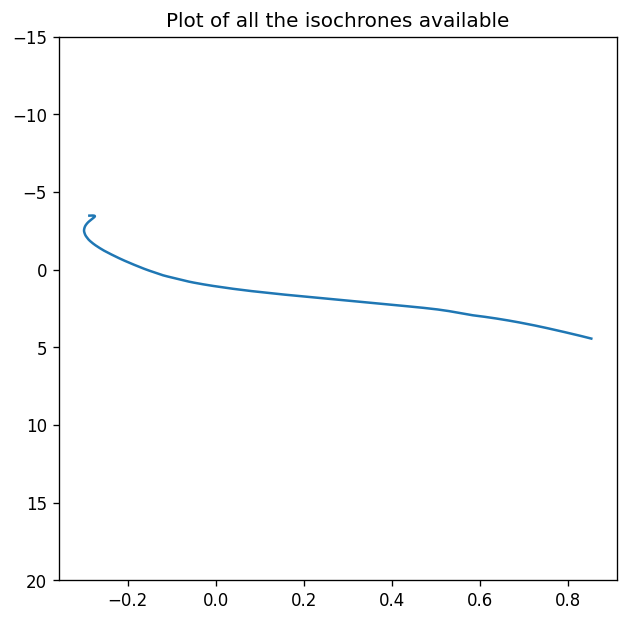

In [39]:
fig = plt.figure(figsize=(6, 6), dpi=120)

plt.plot(isochrone[0,:,column_index('Gaia_BP_EDR3')]-isochrone[0,:,column_index('Gaia_RP_EDR3')], isochrone[0,:,column_index('Gaia_G_EDR3')],
                    )
    
    

plt.title('Plot of all the isochrones available')
plt.ylim(20, -15)

# Find perpendicular distances over all ages

In [54]:
log_l=[]
isocs=[]
idxs=[]
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = np.linspace(8,9.5,10)
for age in logagegrid:
    output=perpendicular_dist(20,age)
    log_l.append(output[0])
    isocs.append(output[1])
    idxs.append(output[2])
    

In [41]:
log_l

[tensor([-0.9498], dtype=torch.float64),
 tensor([-0.9496], dtype=torch.float64),
 tensor([-0.9491], dtype=torch.float64),
 tensor([-0.9479], dtype=torch.float64),
 tensor([-0.9464], dtype=torch.float64),
 tensor([-0.9442], dtype=torch.float64),
 tensor([-0.9410], dtype=torch.float64),
 tensor([-0.9343], dtype=torch.float64),
 tensor([-0.9265], dtype=torch.float64),
 tensor([-0.9191], dtype=torch.float64)]

In [42]:
def isoc_column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0]

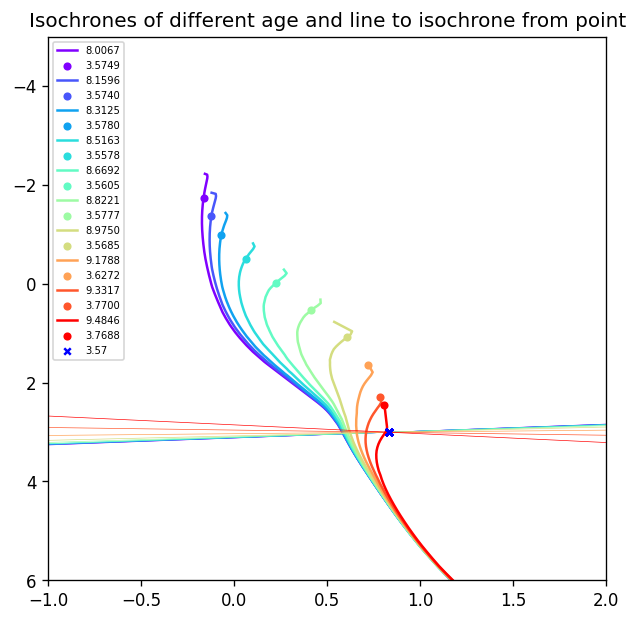

In [55]:
fig = plt.figure(figsize=(6, 6), dpi=120)
n=len(x_columns)
list_logg=[]
p_slopes=[]
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(isocs))))

for i in range(len(isocs)):
    logg=isocs[i][0,:,column_index('logg_gspphot')][0]
    
    c=next(color)
    isochrone=isocs[i]
    plt.plot(isochrone[0,:,column_index('Gaia_BP_EDR3')]-isochrone[0,:,column_index('Gaia_RP_EDR3')], isochrone[0,:,column_index('Gaia_G_EDR3')],label="%.4f" % float(isochrone[0,:,column_index('logage')][1]),c=c)
    idx=find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))[1]
    p_slopes.append(isochrone[0,idxs[i],column_index('p_slopes')])
    plt.axline((isochrone[0,:,column_index('bp_rp')][0],isochrone[0,:,column_index('G')][0]), slope=p_slopes[i], linewidth=0.4, c=c)
    plt.scatter(isochrone[0,int(idx),column_index('BPRP')],isochrone[0,int(idx),column_index('Gaia_G_EDR3')],s=15,marker='o',zorder=10,label="%.4f" % float(isochrone[0,int(idx),column_index('logg')]),color=c)



plt.scatter(isochrone[0,:,column_index('bp_rp')],isochrone[0,:,column_index('G')],s=15,marker='x',zorder=10,color='b',label="%.2f" % float(isochrone[0,:,column_index('logg_gspphot')][1]))


plt.title('Isochrones of different age and line to isochrone from point')
plt.ylim(6, -5)
plt.xlim(-1,2)
plt.legend(loc=2, prop={'size': 6})
plt.show()


In [44]:
find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))
idx=find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))[1]
idx
isochrone[0,int(idx),column_index('logg')]

tensor(3.7688, dtype=torch.float64)

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/matplotlib/transforms.py:775: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  points = np.asarray(points, float)


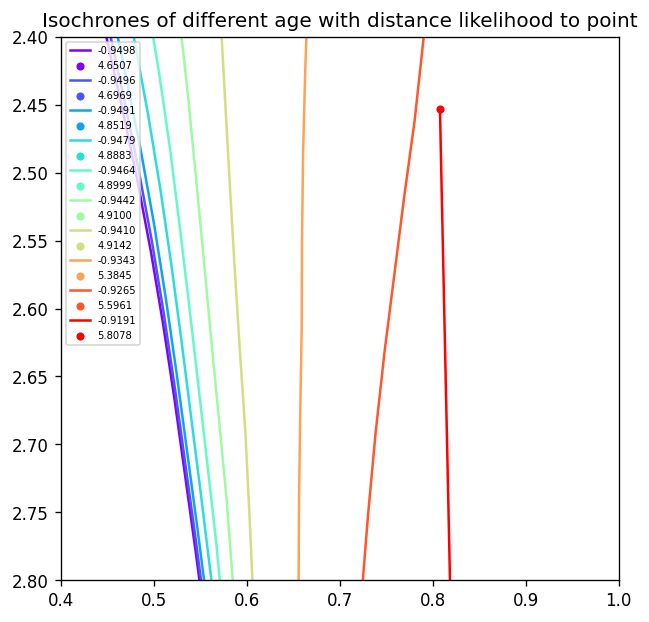

In [45]:
fig = plt.figure(figsize=(6, 6), dpi=120)
n=len(x_columns)
list_logg=[]
p_slopes=[]
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(isocs))))

for i in range(len(isocs)):
    c=next(color)
    isochrone=isocs[i]
    plt.plot(isochrone[0,:,column_index('Gaia_BP_EDR3')]-isochrone[0,:,column_index('Gaia_RP_EDR3')], isochrone[0,:,column_index('Gaia_G_EDR3')],label="%.4f" % float(log_l[i]),c=c)
    idx=find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))[1]
    p_slopes.append(isochrone[0,idxs[i],column_index('p_slopes')])
    plt.axline((isochrone[0,:,column_index('bp_rp')][0],isochrone[0,:,column_index('G')][0]), slope=p_slopes[i], linewidth=0.6, c=c)
    plt.scatter(isochrone[0,:,column_index('bp_rp')],isochrone[0,:,column_index('G')],s=15,marker='x',zorder=10,color='b')
    plt.scatter(isochrone[0,int(idx),column_index('BPRP')],isochrone[0,int(idx),column_index('Gaia_G_EDR3')],s=15,marker='o',zorder=10,label="%.4f" % float(isochrone[0,:,column_index('logg')][1]),color=c)

    try:
        list_logg.append(isochrone[0,int(idx),:])
    except:
        print('err')
        list_logg.append(torch.nan)




    

st=torch.stack(list_logg)
#plt.scatter(st[:,column_index('BPRP')],st[:,column_index('Gaia_G_EDR3')],s=10,color='black',zorder=10)

plt.title('Isochrones of different age with distance likelihood to point')
plt.ylim(2.8, 2.4)
plt.xlim(0.4,1)
plt.legend(loc=2, prop={'size': 6})
plt.show()

In [46]:
dc=st[:,column_index('BPRP')][0]-isochrone[0,:,column_index('bp_rp')][0]
dg=st[:,column_index('Gaia_G_EDR3')][0]-isochrone[0,:,column_index('G')][0]


In [47]:
dc

tensor(-0.9971, dtype=torch.float64)

In [48]:
dg

tensor(-4.7435, dtype=torch.float64)

# One age and one metalicity for many points

In [49]:
log_l=[]
isocs=[]
idxs=[]
massgrid = 10*np.linspace(np.log10(0.1),np.log10(10), 1000)
logagegrid = [8.5]#np.linspace(8,9.5,10)
for age in logagegrid:
    for i in range(int(len(x_values)/50)):
        output=perpendicular_dist(50*i,age)
        log_l.append(output[0])
        isocs.append(output[1])
        idxs.append(output[2])

/Users/mattocallaghan/miniforge3/envs/astro/lib/python3.8/site-packages/matplotlib/transforms.py:775: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  points = np.asarray(points, float)


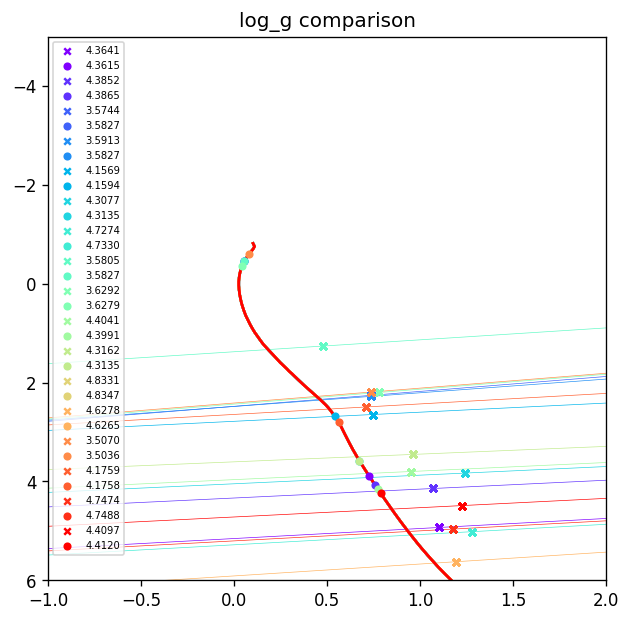

In [50]:
fig = plt.figure(figsize=(6, 6), dpi=120)
n=len(x_columns)
list_logg=[]
p_slopes=[]
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(isocs))))

for i in range(len(isocs)):
    logg=isocs[i][0,:,column_index('logg_gspphot')][0]
    
    c=next(color)
    isochrone=isocs[i]
    plt.plot(isochrone[0,:,column_index('Gaia_BP_EDR3')]-isochrone[0,:,column_index('Gaia_RP_EDR3')], isochrone[0,:,column_index('Gaia_G_EDR3')],c=c)
    idx=find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))[1]
    p_slope=(isochrone[0,idxs[i],column_index('p_slopes')])
    plt.axline((isochrone[0,:,column_index('bp_rp')][0],isochrone[0,:,column_index('G')][0]), slope=p_slope, linewidth=0.4, c=c)
    plt.scatter(isochrone[0,:,column_index('bp_rp')],isochrone[0,:,column_index('G')],s=15,marker='x',zorder=10,label="%.4f" % float(isochrone[0,:,column_index('logg_gspphot')][1]),color=c)
    plt.scatter(isochrone[0,int(idx),column_index('BPRP')],isochrone[0,int(idx),column_index('Gaia_G_EDR3')],s=15,marker='o',zorder=10,label="%.4f" % float(isochrone[0,int(idx),column_index('logg')]),color=c)






    

#st=torch.stack(list_logg)
#plt.scatter(st[:,column_index('BPRP')],st[:,column_index('Gaia_G_EDR3')],s=10,color='black',zorder=10)

plt.title('log_g comparison')
plt.ylim(6, -5)
plt.xlim(-1,2)
plt.legend(loc=2, prop={'size': 6})

plt.show()


In [51]:
find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))
idx=find_nearest(isochrone[0,:,column_index('logg')].nan_to_num(torch.inf),float(logg))[1]
idx
isochrone[0,int(idx),column_index('logg')]

tensor(4.4120, dtype=torch.float64)

In [52]:
logg

tensor(4.4097, dtype=torch.float64)

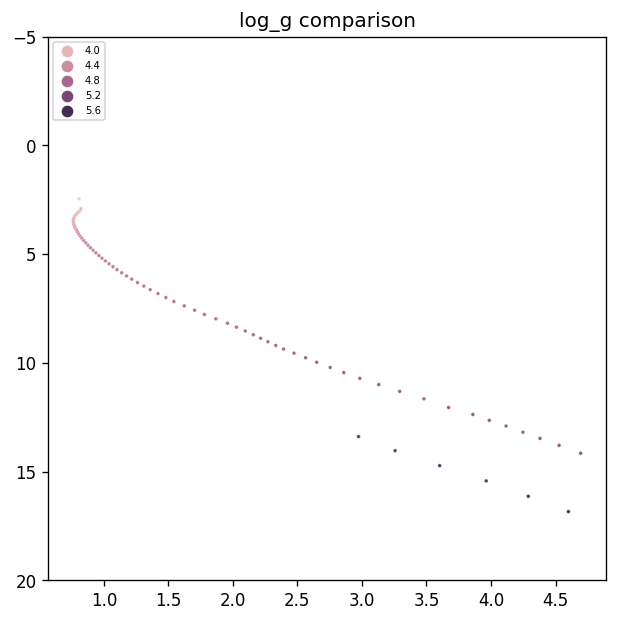

In [60]:
fig = plt.figure(figsize=(6, 6), dpi=120)
n=len(x_columns)
list_logg=[]
p_slopes=[]
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(isocs))))

isochrone=isocs[i]
sn.scatterplot(x=(isochrone[0,:,column_index('Gaia_BP_EDR3')]-isochrone[0,:,column_index('Gaia_RP_EDR3')]),y= isochrone[0,:,column_index('Gaia_G_EDR3')],hue=isochrone[0,:,column_index('logg')],s=5)






    

#st=torch.stack(list_logg)
#plt.scatter(st[:,column_index('BPRP')],st[:,column_index('Gaia_G_EDR3')],s=10,color='black',zorder=10)

plt.title('log_g comparison')
plt.ylim(20, -5)

plt.legend(loc=2, prop={'size': 6})

plt.show()